<!--
Ignore ShapelyDeprecationWarning warning in render

In [1]:
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

-->

# 11 Choropleth maps

In this section we will learn how to join dataframes and will apply this to creating a [choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) with `geopandas`.

## About the data

The first dataset we will use is a [list of Arctic communities and their location](https://search.dataone.org/view/doi%3A10.18739%2FA28S4JQ80) @brook_approximate_2023 created by the [Alaska Native Tribal Health Consortium](https://www.anthc.org). This data comess in GeoJSON file with the following attributes:

- **name**: name of Arctic community, 
- **population**: population of Arctic community, as of 2022
- **country**: country that the Arctic community falls within (see dataset metadata for the codes)
- **geoname-id**: numeric codes that uniquely identify all administrative/legal and statistical geographic areas for which the Census Bureau tabulates data

The second dataset is [Natural Earth's medium scale  cultural boundaries data for countries (1:50m)](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/). 
We can obtain this dataset by downloading the shapefile. 
[Natural Earth](https://www.naturalearthdata.com) is a public domain dataset with ready-to-use data for creating maps. 

## Import data

We will first import the countries shapefile and adapt it for wrangling purposes:

<!--
# will use this library to add a background to our map
import contextily as ctx
-->

In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Import countries polygons
fp = os.path.join('data', 'ne_50m_admin_0_countries', 'ne_50m_admin_0_countries.shp')
countries = gpd.read_file(fp)


In [31]:
us = countries[countries.ADMIN=="United States of America"]
us.explode()

featurecla  scalerank  LABELRANK                SOVEREIGNT  \
16 0    Admin-0 country          5          2  United States of America   
   1    Admin-0 country          5          2  United States of America   
   2    Admin-0 country          5          2  United States of America   
   3    Admin-0 country          5          2  United States of America   
   4    Admin-0 country          5          2  United States of America   
...                 ...        ...        ...                       ...   
   122  Admin-0 country          5          2  United States of America   
   123  Admin-0 country          5          2  United States of America   
   124  Admin-0 country          5          2  United States of America   
   125  Admin-0 country          5          2  United States of America   
   126  Admin-0 country          5          2  United States of America   

       SOV_A3  ADM0_DIF  LEVEL     TYPE TLC                     ADMIN  ...  \
16 0      US1         1      2  Country   1  United States of America  ...   
   1      US1         1      2  Country   1  United States of America  ...   
   2      US1         1      2  Country   1  United States of America  ...   
   3      US1         1      2  Country   1  United States of America  ...   
   4      US1         1      2  Country   1  United States of America  ...   
...       ...       ...    ...      ...  ..                       ...  ...   
   122    US1         1      2  Country   1  United States of America  ...   
   123    US1         1      2  Country   1  United States of America  ...   
   124    US1         1      2  Country   1  United States of America  ...   
   125    US1         1      2  Country   1  United States of America  ...   
   126    US1         1      2  Country   1  United States of America  ...   

       FCLASS_TR  FCLASS_ID FCLASS_PL FCLASS_GR  FCLASS_IT FCLASS_NL  \
16 0        None       None      None      None       None      None   
   1        None       None      None      None       None      None   
   2        None       None      None      None       None      None   
   3        None       None      None      None       None      None   
   4        None       None      None      None       None      None   
...          ...        ...       ...       ...        ...       ...   
   122      None       None      None      None       None      None   
   123      None       None      None      None       None      None   
   124      None       None      None      None       None      None   
   125      None       None      None      None       None      None   
   126      None       None      None      None       None      None   

       FCLASS_SE  FCLASS_BD FCLASS_UA  \
16 0        None       None      None   
   1        None       None      None   
   2        None       None      None   
   3        None       None      None   
   4        None       None      None   
...          ...        ...       ...   
   122      None       None      None   
   123      None       None      None   
   124      None       None      None   
   125      None       None      None   
   126      None       None      None   

                                                 geometry  
16 0    POLYGON ((-132.74687 56.52568, -132.75762 56.5...  
   1    POLYGON ((-132.77988 56.24727, -132.83096 56.2...  
   2    POLYGON ((-134.31274 58.22891, -134.31987 58.2...  
   3    POLYGON ((-145.11851 60.33711, -145.15049 60.3...  
   4    POLYGON ((-144.56563 59.81841, -144.61357 59.8...  
...                                                   ...  
   122  POLYGON ((-122.85308 47.20474, -122.86260 47.1...  
   123  POLYGON ((-122.39414 47.39526, -122.39873 47.3...  
   124  POLYGON ((-122.49727 47.59458, -122.50264 47.5...  
   125  POLYGON ((-122.82090 48.43135, -122.83657 48.4...  
   126  POLYGON ((-68.62319 44.19604, -68.66118 44.176...  

[127 rows x 169 columns]

In [ ]:

# Simplify column names
countries.columns = countries.columns.str.lower()

# Select columns for analysis
countries = countries[['admin', 'type', 'geometry']]

countries.head()

<Axes: >

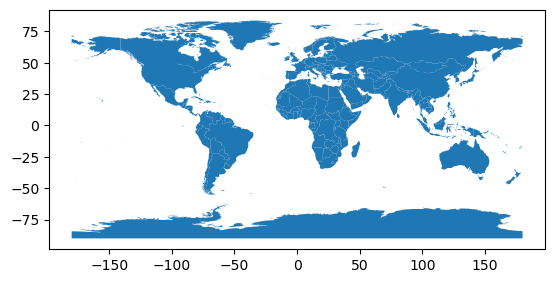

In [3]:
# Quick view
countries.plot()

Next, we import the Arctic communitites data. In the same way as we previously used `pandas.read_csv()`, we can read in the Arctic communities GeoJSON data directly from the data repository using `geopandas.read_file()`:

In [4]:
# Import Arctic communities data
URL = 'https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Aed7718ae-fb0d-43dd-9270-fbfe80bfc7a4'
communities = gpd.read_file(URL)

communities.head()

,name,population,country,geoname-id,geometry
0,Udomlya,32373,RU,452949,POINT (34.99250 57.87944)
1,Valmiera,26963,LV,453754,POINT (25.42751 57.54108)
2,Ventspils,42644,LV,454310,POINT (21.57288 57.38988)
3,Vec-Liepāja,85260,LV,454432,POINT (21.01667 56.53333)
4,Tukums,18348,LV,454768,POINT (23.15528 56.96694)


The CRS of the `communitites` is EPSG:4326. Remember all GeoJSON files are given in this CRS and all points are expressed in longitude and latitude units of decimal degrees. In this case, the `countries` and `communities` GeoDataFrames both have the same CRS:

In [5]:
print(countries.crs)

# Verify CRSs match
assert countries.crs == communities.crs

EPSG:4326


Since the CRSs match, it is easy to take a quick look at our communities data by plotting it on top of the countries dataframe:

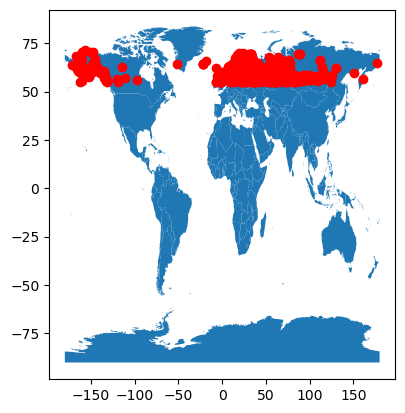

In [6]:
fig, ax = plt.subplots()
countries.plot(ax=ax)
communities.plot(ax=ax, color='red')
plt.show()

## Arctic communities by country

Next, we want to calculate the number of Arctic communities by country. 

In [7]:
# Create data frame with number of communities per country
n_comms = (communities.groupby('country')
                      .size()
                      .reset_index(name='n_communities'))

Let's break this down a bit:

- We start with our `communities` dataframe and use `groupby('country')` to group by country code, 
- then we use [`size()`](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.size.html) as an aggregator function to calculate the size of each group.
- The result of this operation is a `pandas.Series` indexed by the `country` values.
- By resetting the index we transform the `pandas.Series` into a `pandas.DataFrame`, the index is now a column named `country` and the values of the series are named `n_communities`.

In [8]:
# Number of Arctic communities per country
n_comms

,country,n_communities
0,AX,1
1,BY,8
2,CA,7
3,DK,72
4,EE,14
5,FI,98
6,FO,1
7,GB,96
8,GL,1
9,IS,5


## `if`-`else` statements

Our goal is to merge the `n_comms` and the `countries` data frames. To merge two data frames they need to have at least one column in common. 
Currently our datasets do not have any columns in common:

In [9]:
set(countries.columns).intersection(n_comms.columns)

set()

The output `set()` represents the empty set. This might be as informative, so let's write a different information statement:

In [10]:
common_columns = set(countries.columns).intersection(n_comms.columns)

# Check if there are any common columns
if len(common_columns) != 0:
    print(f"Common columns: {common_columns}")
else:
    print("No common columns")

No common columns


Remember that an `if-else` statement is a control structure that allows code to make decisions: it checks a condition, and if that condition is true, it executes one block of code (the `if` block); if the condition is false, it executes a different block (the `else` block). This enables programs to respond differently depending on specific criteria or inputs.

:::{.callout-tip}
## Check-in
Wrap up the previous code into a function called `check_common_columns` that prints a message depending of whether two data frames have common columns or not. Do not forget to include a docstring!
<!--

In [11]:
def check_common_columns(df1, df2):
    """
    Prints a message depending whether df1 and df2 have columns in common

     Parameters:
    - df1: The first DataFrame.
    - df2: The second DataFrame.
    
    Returns:
    - A set of common column names. If no columns are common, returns an empty set.
    """

    common_columns = set(df1.columns).intersection(df2.columns)
    
    if common_columns:
        print(f"Common columns: {common_columns}")
    else:
        print("No common columns")
    
    return 

-->
:::

## Merging data frames

Based on the metadata of both datasets, we have created the following code with the complete names of the countries given the code in the Arctic communities data:

In [12]:
# Text data as a dictionary
dict = {
    "RU": "Russia", "LV": "Latvia", "EE": "Estonia", "LT": "Lithuania",
    "SE": "Sweden", "BY": "Belarus", "FI": "Finland", "NO": "Norway",
    "DK": "Denmark", "FO": "Faroe Islands", "IS": "Iceland",
    "GB": "United Kingdom",
    "AX": "Aland Islands", "GL": "Greenland", "US": "United States of America", "CA": "Canada"
}

# Convert the dictionary to a DataFrame
country_names = pd.DataFrame(list(dict.items()), columns=["country", "admin"])
country_names

,country,admin
0,RU,Russia
1,LV,Latvia
2,EE,Estonia
3,LT,Lithuania
4,SE,Sweden
5,BY,Belarus
6,FI,Finland
7,NO,Norway
8,DK,Denmark
9,FO,Faroe Islands


We can use this to add the names countries into the `n_comms` data which, in turn, will allow us to merge that data frame with the `country_names` data. To merge dataframes we can use the [`pandas.merge()` function](https://pandas.pydata.org/docs/reference/api/pandas.merge.html#pandas.merge). 
The basic syntax for it is:

```python
output_df = pd.merge(left_df,
                     right_df, 
                     how = type_of_join, 
                     on = column_to_join)
```
where

- `output_df` is the dataframe resulting from the merge,
- `left_df` is the dataframe we have "on the left side",
- `right_df` is the dataframe we have "on the right side",
- `how` specifies the type of join between the left and right dataframes, ([check the options here](https://pandas.pydata.org/docs/reference/api/pandas.merge.html#pandas.merge)), the default is to do an inner join,
- `on` specifies the column to join on, this column must be present in both our dataframes. 

So, we merge the `n_comms` and `country_names` data frames using a left join:

![Image source: Data Modeling Essentials, NCEAS Learning Hub @do-linh_open_2023](/book/images/merging_data/join-diagrams-left.png)

In [13]:
n_comms = pd.merge(n_comms,
                   country_names,
                   how='left',
                   on='country')
n_comms

,country,n_communities,admin
0,AX,1,Aland Islands
1,BY,8,Belarus
2,CA,7,Canada
3,DK,72,Denmark
4,EE,14,Estonia
5,FI,98,Finland
6,FO,1,Faroe Islands
7,GB,96,United Kingdom
8,GL,1,Greenland
9,IS,5,Iceland


We can reuse our function to check that `n_comms` and `countries` now have a common column on which we can merge them:

In [14]:
check_common_columns(n_comms, countries)

Common columns: {'admin'}


:::{.callout-tip}
## Check-in
Perform an inner join between our `countries` and `n_comms` dataframes. This will merge the subset of rows that have matches in both the left table and the right table.

![Image source: Data Modeling Essentials, NCEAS Learning Hub @do-linh_open_2023](/book/images/merging_data/join-diagrams-inner.png)
<!--

In [15]:
# Merge data frames 
arctic_countries = pd.merge(countries,
                            n_comms,
                            how='inner',
                            on='admin')
# Update index
arctic_countries = arctic_countries.set_index('admin')

-->
:::

## Reviewing results

Notice that the row for Aland Islands is not present in the merged dataframe:

In [16]:
arctic_countries

,type,geometry,country,n_communities
admin,,,,
United States of America,Country,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576...",US,115
United Kingdom,Country,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51...",GB,96
Sweden,Sovereign country,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57...",SE,133
Russia,Sovereign country,"MULTIPOLYGON (((145.88154 43.45952, 145.89561 ...",RU,774
Norway,Sovereign country,"MULTIPOLYGON (((20.62217 69.03687, 20.49199 69...",NO,48
Lithuania,Sovereign country,"MULTIPOLYGON (((20.95781 55.27891, 20.89980 55...",LT,26
Latvia,Sovereign country,"POLYGON ((26.59355 55.66753, 26.54287 55.67241...",LV,25
Iceland,Sovereign country,"POLYGON ((-15.54312 66.22852, -15.42847 66.224...",IS,5
Finland,Country,"MULTIPOLYGON (((24.15547 65.80527, 24.04902 65...",FI,98


The `values` attribute of a data frame returns *all* the values in the data frame as an array. We can verify the value 'Aland Islands' was *nowhere* in our original countries dataframe like this:

In [17]:
# Check Aland Islands is nowhere in data frame
'Aland Islands' not in countries.values

True

The Aland Islands is an autonomous region of Finland and there is one Arctic community registered in this region. 
We will directly add one to Finland to not lose this piece of data:

In [18]:
arctic_countries.at['Finland', 'n_communities'] += 1

## Choropleth map

A [choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) is an efficient way to visualize aggregate data per region. 

Making a choropleth map from our polygons `GeoDataFrame` is easy, we just need to specify the `column` parameter in `plot()` and make it equal to the column with the values we want to plot in each country:

<Axes: >

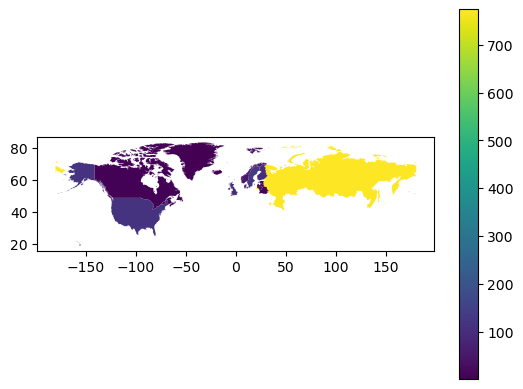

In [19]:
arctic_countries.plot(column='n_communities',
                      legend=True)

To finish, we can use `matplotlib` to customize our map:

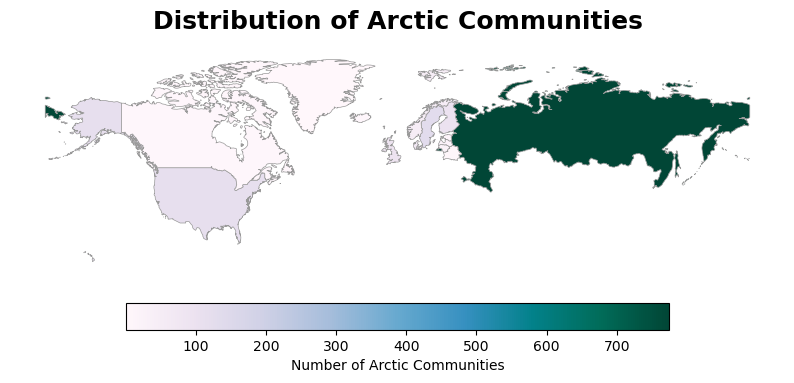

In [20]:
#| code-fold: true
#| 
fig, ax = plt.subplots(figsize=(10, 8))

# Remove the axis for a cleaner map
ax.axis('off')

# Create choropleth map of communities
# Plot with refined color and edge style
arctic_countries.plot(
    ax=ax,
    column='n_communities',
    cmap='PuBuGn',
    legend=True,
    edgecolor="0.6",
    linewidth=0.5,
    legend_kwds={
        "shrink": 0.7,
        "label": "Number of Arctic Communities",
        "orientation": "horizontal",
        "pad": 0.05
    }
)

# Add title and subtitle for better context
ax.set_title('Distribution of Arctic Communities', fontsize=18, weight='bold', pad=15)

plt.show()

<Axes: >

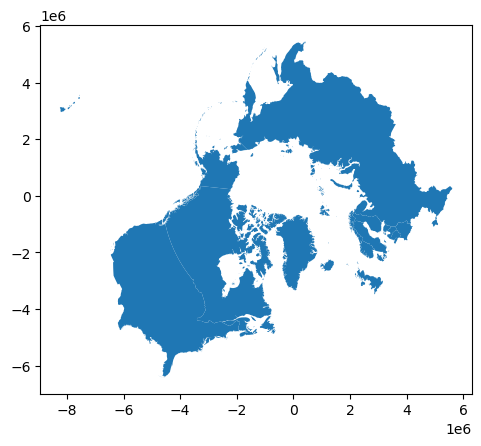

In [21]:
arctic_countries = arctic_countries.to_crs('epsg:3413')
arctic_countries.plot()

In [23]:
arctic_countries

,type,geometry,country,n_communities
admin,,,,
United States of America,Country,"MULTIPOLYGON (((-3725925.296 -146595.535, -372...",US,115
United Kingdom,Country,"MULTIPOLYGON (((2904994.768 -3188931.508, 2904...",GB,96
Sweden,Sovereign country,"MULTIPOLYGON (((3215304.166 -1562900.287, 3215...",SE,133
Russia,Sovereign country,"MULTIPOLYGON (((-1005666.554 5231427.614, -100...",RU,774
Norway,Sovereign country,"MULTIPOLYGON (((2090870.997 -947485.892, 20890...",NO,48
Lithuania,Sovereign country,"MULTIPOLYGON (((3539821.187 -1579154.031, 3537...",LT,26
Latvia,Sovereign country,"POLYGON ((3634133.643 -1209369.426, 3632514.63...",LV,25
Iceland,Sovereign country,"POLYGON ((1284103.045 -2273634.774, 1288856.83...",IS,5
Finland,Country,"MULTIPOLYGON (((2484995.257 -946171.872, 24637...",FI,99
